In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from datetime import datetime

from sklearn.metrics import mean_squared_error

from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_forecast_component

import warnings
warnings.filterwarnings("ignore")

In [2]:
# global setting for DataFrames and visualizations
pd.set_option("display.max_columns", None)
plt.rc("figure", figsize=(16, 8))
sns.set_palette("colorblind")

# Wrangle
Data sourced [here](https://www.kaggle.com/tevecsystems/retail-sales-forecasting).

In [3]:
df = pd.read_csv("datasets_1789_3097_mock_kaggle.csv")
df

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


In [4]:
df.isna().sum()

data       0
venda      0
estoque    0
preco      0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     937 non-null    object 
 1   venda    937 non-null    int64  
 2   estoque  937 non-null    int64  
 3   preco    937 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 29.4+ KB


In [6]:
df["data"] = pd.to_datetime(df.data)
df

,data,venda,estoque,preco
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     937 non-null    datetime64[ns]
 1   venda    937 non-null    int64         
 2   estoque  937 non-null    int64         
 3   preco    937 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 29.4 KB


In [8]:
df.rename(
    columns={"data": "date", "venda": "sale", "estoque": "stock", "preco": "price"},
    inplace=True,
)
df

,date,sale,stock,price
0,2014-01-01,0,4972,1.29
1,2014-01-02,70,4902,1.29
2,2014-01-03,59,4843,1.29
3,2014-01-04,93,4750,1.29
4,2014-01-05,96,4654,1.29
...,...,...,...,...
932,2016-07-27,98,3179,2.39
933,2016-07-28,108,3071,2.39
934,2016-07-29,128,4095,2.39
935,2016-07-30,270,3825,2.39


In [9]:
df["revenue"] = df.sale * df.price
df

,date,sale,stock,price,revenue
0,2014-01-01,0,4972,1.29,0.00
1,2014-01-02,70,4902,1.29,90.30
2,2014-01-03,59,4843,1.29,76.11
3,2014-01-04,93,4750,1.29,119.97
4,2014-01-05,96,4654,1.29,123.84
...,...,...,...,...,...
932,2016-07-27,98,3179,2.39,234.22
933,2016-07-28,108,3071,2.39,258.12
934,2016-07-29,128,4095,2.39,305.92
935,2016-07-30,270,3825,2.39,645.30


In [10]:
df = df.sort_values(by="date").set_index("date")
df

,sale,stock,price,revenue
date,,,,
2014-01-01,0,4972,1.29,0.00
2014-01-02,70,4902,1.29,90.30
2014-01-03,59,4843,1.29,76.11
2014-01-04,93,4750,1.29,119.97
2014-01-05,96,4654,1.29,123.84
...,...,...,...,...
2016-07-27,98,3179,2.39,234.22
2016-07-28,108,3071,2.39,258.12
2016-07-29,128,4095,2.39,305.92


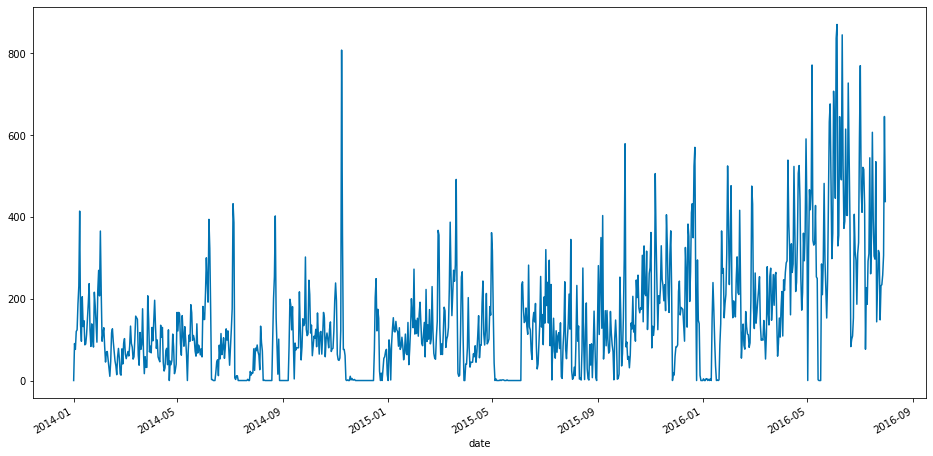

In [11]:
df.revenue.plot()
plt.show()

In [12]:
df = pd.DataFrame(df[["revenue"]])
df

,revenue
date,
2014-01-01,0.00
2014-01-02,90.30
2014-01-03,76.11
2014-01-04,119.97
2014-01-05,123.84
...,...
2016-07-27,234.22
2016-07-28,258.12
2016-07-29,305.92


In [13]:
df[:"2015-12-31"].shape[0] / df.shape[0]

0.7726787620064034

In [14]:
def prep_data(df):
    return (
        df.assign(ds=pd.to_datetime(df.date))
        .sort_values("ds")
        .assign(y=df.revenue)
        .groupby(["ds"])["y"]
        .sum()
        .reset_index()
        .set_index("ds")
    )

In [15]:
df = df.reset_index()
df

,date,revenue
0,2014-01-01,0.00
1,2014-01-02,90.30
2,2014-01-03,76.11
3,2014-01-04,119.97
4,2014-01-05,123.84
...,...,...
932,2016-07-27,234.22
933,2016-07-28,258.12
934,2016-07-29,305.92
935,2016-07-30,645.30


In [16]:
df = prep_data(df)
df

,y
ds,
2014-01-01,0.00
2014-01-02,90.30
2014-01-03,76.11
2014-01-04,119.97
2014-01-05,123.84
...,...
2016-07-27,234.22
2016-07-28,258.12
2016-07-29,305.92


# Preprocessing

In [17]:
train = df[:"2015-12-31"]
test = df["2016-01-01":]

In [18]:
train

,y
ds,
2014-01-01,0.00
2014-01-02,90.30
2014-01-03,76.11
2014-01-04,119.97
2014-01-05,123.84
...,...
2015-12-27,147.34
2015-12-28,139.00
2015-12-29,12.51


In [19]:
test.shape[0] / df.shape[0]

0.22732123799359658

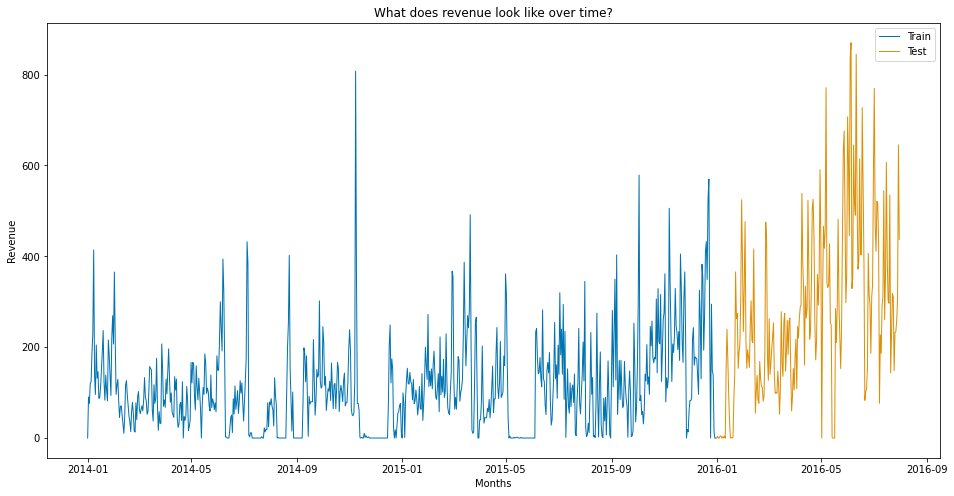

In [20]:
# plot the train and test DataFrames
plt.plot(train, label="Train", linewidth=1)
plt.plot(test, label="Test", linewidth=1)

# labels
plt.title("What does revenue look like over time?")
plt.xlabel("Months")
plt.ylabel("Revenue")
plt.legend()
plt.show()

In [21]:
train.max()

y    807.58
dtype: float64

In [22]:
train["cap"] = 850

In [23]:
train

,y,cap
ds,,
2014-01-01,0.00,850
2014-01-02,90.30,850
2014-01-03,76.11,850
2014-01-04,119.97,850
2014-01-05,123.84,850
...,...,...
2015-12-27,147.34,850
2015-12-28,139.00,850
2015-12-29,12.51,850


In [24]:
train.min()

y        0.0
cap    850.0
dtype: float64

In [25]:
train["floor"] = 0

In [26]:
train

,y,cap,floor
ds,,,
2014-01-01,0.00,850,0
2014-01-02,90.30,850,0
2014-01-03,76.11,850,0
2014-01-04,119.97,850,0
2014-01-05,123.84,850,0
...,...,...,...
2015-12-27,147.34,850,0
2015-12-28,139.00,850,0
2015-12-29,12.51,850,0


In [27]:
train = train.reset_index()
test = test.reset_index()
train

,ds,y,cap,floor
0,2014-01-01,0.00,850,0
1,2014-01-02,90.30,850,0
2,2014-01-03,76.11,850,0
3,2014-01-04,119.97,850,0
4,2014-01-05,123.84,850,0
...,...,...,...,...
719,2015-12-27,147.34,850,0
720,2015-12-28,139.00,850,0
721,2015-12-29,12.51,850,0
722,2015-12-30,0.00,850,0


# Forecast
## Facebook Prophet

In [28]:
m = Prophet(growth="logistic", yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.add_country_holidays("Brazil")
m.fit(train)

In [29]:
print(m.train_holiday_names)

0                New Year's Day
1                    Tiradentes
2                  Worker's Day
3              Independence Day
4    Our Lady of the Apparition
5                All Souls' Day
6     Republic Proclamation Day
7                     Christmas
dtype: object


### Predict
#### Future

In [30]:
# future through test observations
future = m.make_future_dataframe(periods=len(test))
future["cap"] = 850
future["floor"] = 0

In [31]:
future

,ds,cap,floor
0,2014-01-01,850,0
1,2014-01-02,850,0
2,2014-01-03,850,0
3,2014-01-04,850,0
4,2014-01-05,850,0
...,...,...,...
932,2016-07-27,850,0
933,2016-07-28,850,0
934,2016-07-29,850,0
935,2016-07-30,850,0


In [32]:
forecast = m.predict(future)
forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,All Souls' Day,All Souls' Day_lower,All Souls' Day_upper,Christmas,Christmas_lower,Christmas_upper,Independence Day,Independence Day_lower,Independence Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Our Lady of the Apparition,Our Lady of the Apparition_lower,Our Lady of the Apparition_upper,Republic Proclamation Day,Republic Proclamation Day_lower,Republic Proclamation Day_upper,Tiradentes,Tiradentes_lower,Tiradentes_upper,Worker's Day,Worker's Day_lower,Worker's Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,89.847942,850,0,-112.588331,109.742403,89.847942,89.847942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-113.055906,-113.055906,-113.055906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-91.378831,-91.378831,-91.378831,-113.055906,-113.055906,-113.055906,-4.429305,-4.429305,-4.429305,26.106380,26.106380,26.106380,0.0,0.0,0.0,-1.530890
1,2014-01-02,89.850440,850,0,-18.789347,197.970224,89.850440,89.850440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.497714,3.497714,3.497714,0.000000,0.000000,0.000000,-18.168138,-18.168138,-18.168138,21.665852,21.665852,21.665852,0.0,0.0,0.0,93.348155
2,2014-01-03,89.852939,850,0,-3.347786,218.533954,89.852939,89.852939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.520396,17.520396,17.520396,0.000000,0.000000,0.000000,0.106633,0.106633,0.106633,17.413763,17.413763,17.413763,0.0,0.0,0.0,107.373335
3,2014-01-04,89.855438,850,0,55.791857,275.965391,89.855438,89.855438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.606715,80.606715,80.606715,0.000000,0.000000,0.000000,67.142642,67.142642,67.142642,13.464072,13.464072,13.464072,0.0,0.0,0.0,170.462153
4,2014-01-05,89.857937,850,0,-12.542119,219.396533,89.857937,89.857937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.307000,17.307000,17.307000,0.000000,0.000000,0.000000,7.385341,7.385341,7.385341,9.921659,9.921659,9.921659,0.0,0.0,0.0,107.164937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,2016-07-27,191.635254,850,0,25.695927,253.145307,187.422235,195.445950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-59.602831,-59.602831,-59.602831,0.000000,0.000000,0.000000,-4.429305,-4.429305,-4.429305,-55.173526,-55.173526,-55.173526,0.0,0.0,0.0,132.032424
933,2016-07-28,191.825675,850,0,5.414451,226.268280,187.598402,195.670957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-74.377347,-74.377347,-74.377347,0.000000,0.000000,0.000000,-18.168138,-18.168138,-18.168138,-56.209209,-56.209209,-56.209209,0.0,0.0,0.0,117.448328
934,2016-07-29,192.016229,850,0,16.476758,245.530666,187.804051,195.896146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-56.829732,-56.829732,-56.829732,0.000000,0.000000,0.000000,0.106633,0.106633,0.106633,-56.936365,-56.936365,-56.936365,0.0,0.0,0.0,135.186497
935,2016-07-30,192.206917,850,0,98.567211,312.688790,187.942497,196.121515,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.792523,9.792523,9.792523,0.000000,0.000000,0.000000,67.142642,67.142642,67.142642,-57.350119,-57.350119,-57.350119,0.0,0.0,0.0,201.999440


### Evaluate

In [33]:
prophet_evaluation = df.merge(forecast[["ds", "yhat"]], how="inner", on="ds")
prophet_evaluation

,ds,y,yhat
0,2014-01-01,0.00,-1.530890
1,2014-01-02,90.30,93.348155
2,2014-01-03,76.11,107.373335
3,2014-01-04,119.97,170.462153
4,2014-01-05,123.84,107.164937
...,...,...,...
932,2016-07-27,234.22,132.032424
933,2016-07-28,258.12,117.448328
934,2016-07-29,305.92,135.186497
935,2016-07-30,645.30,201.999440


In [34]:
rmse = sqrt(mean_squared_error(prophet_evaluation.y, prophet_evaluation.yhat))
rmse

123.87414528087375

In [35]:
evaluations = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
evaluations

,model_type,target_var,rmse


In [36]:
prophet_data = pd.DataFrame(
        {"model_type": "Facebook Prophet", "target_var": "revenue", "rmse": [rmse]}
    )

evaluations = evaluations.append(prophet_data, ignore_index = True)
evaluations.sort_values(by="rmse")

,model_type,target_var,rmse
0,Facebook Prophet,revenue,123.874145


### Plot

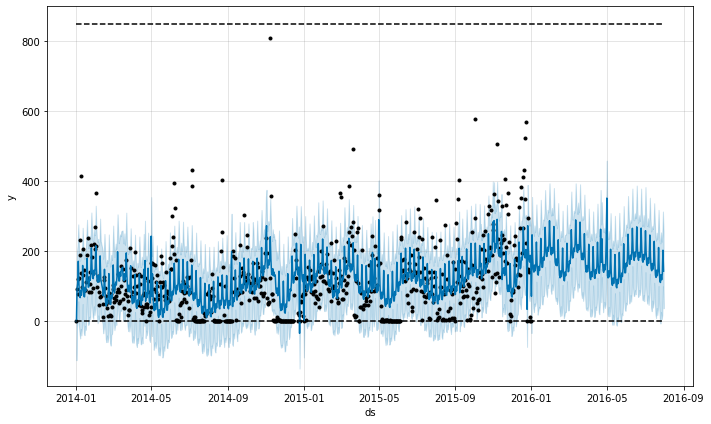

In [37]:
fig = m.plot(forecast)

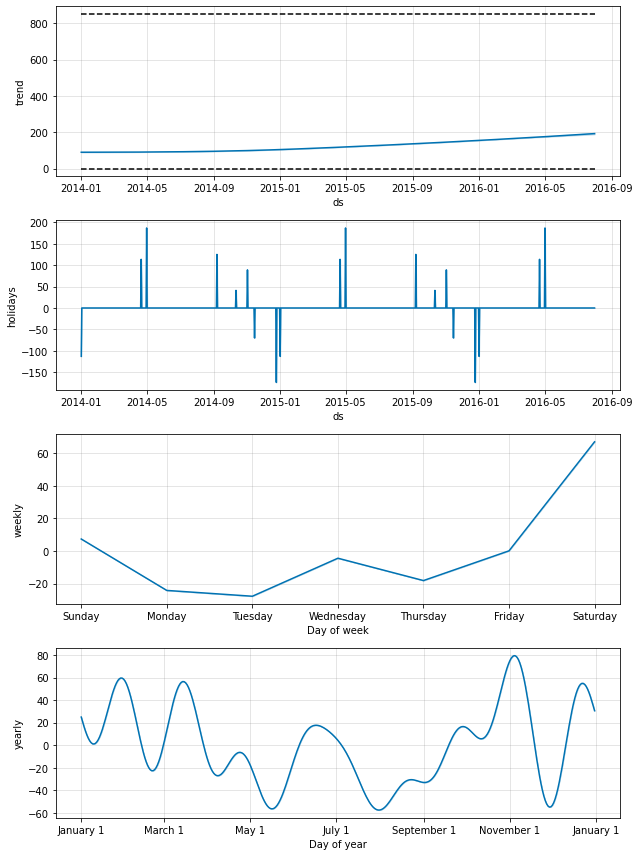

In [38]:
fig = m.plot_components(forecast)

### Predict
#### 2016 EOY - 2018 EOY

In [39]:
# future through 2016 EOY
future = m.make_future_dataframe(periods=1096)
future["cap"] = 850
future["floor"] = 0

In [40]:
future

,ds,cap,floor
0,2014-01-01,850,0
1,2014-01-02,850,0
2,2014-01-03,850,0
3,2014-01-04,850,0
4,2014-01-05,850,0
...,...,...,...
1815,2018-12-27,850,0
1816,2018-12-28,850,0
1817,2018-12-29,850,0
1818,2018-12-30,850,0


In [41]:
forecast = m.predict(future)
forecast

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,All Souls' Day,All Souls' Day_lower,All Souls' Day_upper,Christmas,Christmas_lower,Christmas_upper,Independence Day,Independence Day_lower,Independence Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Our Lady of the Apparition,Our Lady of the Apparition_lower,Our Lady of the Apparition_upper,Republic Proclamation Day,Republic Proclamation Day_lower,Republic Proclamation Day_upper,Tiradentes,Tiradentes_lower,Tiradentes_upper,Worker's Day,Worker's Day_lower,Worker's Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-01-01,89.847942,850,0,-105.982541,111.073496,89.847942,89.847942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-113.055906,-113.055906,-113.055906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-91.378831,-91.378831,-91.378831,-113.055906,-113.055906,-113.055906,-4.429305,-4.429305,-4.429305,26.106380,26.106380,26.106380,0.0,0.0,0.0,-1.530890
1,2014-01-02,89.850440,850,0,-14.069129,196.244218,89.850440,89.850440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.497714,3.497714,3.497714,0.000000,0.000000,0.000000,-18.168138,-18.168138,-18.168138,21.665852,21.665852,21.665852,0.0,0.0,0.0,93.348155
2,2014-01-03,89.852939,850,0,-0.708221,214.508962,89.852939,89.852939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.520396,17.520396,17.520396,0.000000,0.000000,0.000000,0.106633,0.106633,0.106633,17.413763,17.413763,17.413763,0.0,0.0,0.0,107.373335
3,2014-01-04,89.855438,850,0,58.028321,283.072372,89.855438,89.855438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80.606715,80.606715,80.606715,0.000000,0.000000,0.000000,67.142642,67.142642,67.142642,13.464072,13.464072,13.464072,0.0,0.0,0.0,170.462153
4,2014-01-05,89.857937,850,0,2.256452,212.199570,89.857937,89.857937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.307000,17.307000,17.307000,0.000000,0.000000,0.000000,7.385341,7.385341,7.385341,9.921659,9.921659,9.921659,0.0,0.0,0.0,107.164937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1815,2018-12-27,403.392559,850,0,308.411238,554.617000,328.429758,475.997790,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.493121,29.493121,29.493121,0.000000,0.000000,0.000000,-18.168138,-18.168138,-18.168138,47.661258,47.661258,47.661258,0.0,0.0,0.0,432.885680
1816,2018-12-28,403.664383,850,0,315.171073,581.352102,328.610835,476.385412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,44.344138,44.344138,44.344138,0.000000,0.000000,0.000000,0.106633,0.106633,0.106633,44.237506,44.237506,44.237506,0.0,0.0,0.0,448.008521
1817,2018-12-29,403.936223,850,0,385.768163,643.062196,328.791949,476.781664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.506782,107.506782,107.506782,0.000000,0.000000,0.000000,67.142642,67.142642,67.142642,40.364140,40.364140,40.364140,0.0,0.0,0.0,511.443005
1818,2018-12-30,404.208081,850,0,321.261620,568.174016,328.951989,477.177824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.542469,43.542469,43.542469,0.000000,0.000000,0.000000,7.385341,7.385341,7.385341,36.157129,36.157129,36.157129,0.0,0.0,0.0,447.750551


### Evaluate

In [42]:
prophet_evaluation = df.merge(forecast[["ds", "yhat"]], how="left", on="ds")
prophet_evaluation

,ds,y,yhat
0,2014-01-01,0.00,-1.530890
1,2014-01-02,90.30,93.348155
2,2014-01-03,76.11,107.373335
3,2014-01-04,119.97,170.462153
4,2014-01-05,123.84,107.164937
...,...,...,...
932,2016-07-27,234.22,132.032424
933,2016-07-28,258.12,117.448328
934,2016-07-29,305.92,135.186497
935,2016-07-30,645.30,201.999440


In [43]:
rmse = sqrt(mean_squared_error(prophet_evaluation.y, prophet_evaluation.yhat))
rmse

123.87414528087375

### Plot

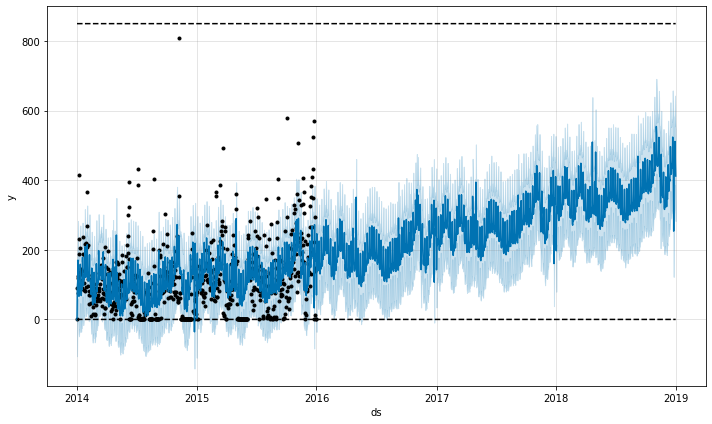

In [44]:
fig = m.plot(forecast)

In [45]:
df["2014"].sum()[0]

31409.72

In [46]:
df["2015"].sum()[0]

48602.46

In [47]:
# 2016 revenue through July 31
df["2016"].sum()[0]

58875.66000000001

In [48]:
# 2016 predicted revenue 
forecast.set_index("ds")["2016"].yhat.sum()

68939.48152766359

In [49]:
# 2016 predicted revenue 
forecast.set_index("ds")["2017"].yhat.sum()

96737.54164272103

In [50]:
# 2016 predicted revenue 
forecast.set_index("ds")["2018"].yhat.sum()

130035.45203785796

### Predict
#### Cross Validation

In [51]:
train.shape

(724, 4)

In [52]:
test.shape

(213, 2)

In [53]:
df_cv = cross_validation(m, initial="548 days", horizon="90 days")
df_cv

INFO:fbprophet:Making 3 forecasts with cutoffs between 2015-07-04 00:00:00 and 2015-10-02 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-07-05,134.543215,39.468840,229.589827,239.94,2015-07-04
1,2015-07-06,96.235850,-5.178429,193.754133,140.61,2015-07-04
2,2015-07-07,89.534002,-4.440904,186.498849,294.12,2015-07-04
3,2015-07-08,111.006989,15.088119,209.530866,85.14,2015-07-04
4,2015-07-09,101.921472,8.377370,202.818244,234.78,2015-07-04
...,...,...,...,...,...,...
265,2015-12-27,152.375398,53.755684,248.364955,147.34,2015-10-02
266,2015-12-28,123.912660,26.387087,227.217732,139.00,2015-10-02
267,2015-12-29,121.899388,20.326962,220.226667,12.51,2015-10-02
268,2015-12-30,146.885189,46.458051,256.830722,0.00,2015-10-02


In [54]:
df_cv.cutoff.value_counts()

2015-10-02    90
2015-08-18    90
2015-07-04    90
Name: cutoff, dtype: int64

### Evaluate

In [55]:
df_p = performance_metrics(df_cv)

INFO:fbprophet:Skipping MAPE because y close to 0


In [56]:
df_p

,horizon,mse,rmse,mae,mdape,coverage
0,9 days,11975.598621,109.433078,81.090164,0.636563,0.740741
1,10 days,6869.295670,82.881214,67.167236,0.565885,0.777778
2,11 days,6670.822663,81.675104,64.680218,0.512200,0.777778
3,12 days,4973.643112,70.524061,55.660094,0.486106,0.814815
4,13 days,3962.137844,62.945515,50.676995,0.455378,0.851852
...,...,...,...,...,...,...
77,86 days,32857.847177,181.267336,134.458391,0.467694,0.555556
78,87 days,30386.590426,174.317499,125.612325,0.448108,0.592593
79,88 days,28100.014504,167.630589,123.226135,0.448108,0.518519
80,89 days,28659.960991,169.292531,126.577600,0.467694,0.481481


### Plot

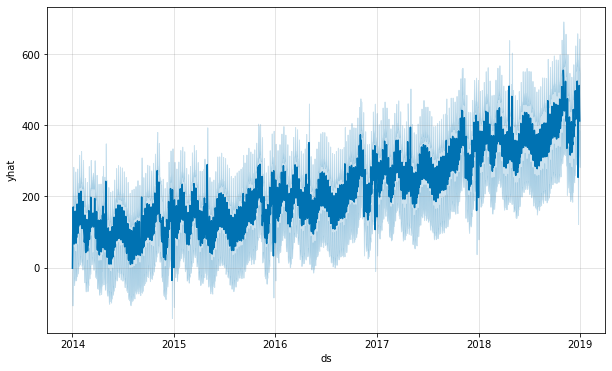

In [57]:
plot_forecast_component(m, forecast, "yhat")

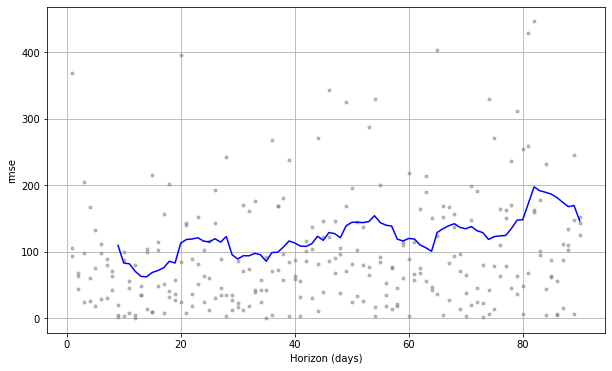

In [58]:
fig = plot_cross_validation_metric(df_cv, metric="rmse")

In [59]:
# fig = plot_cross_validation_metric(df_cv, metric="mape")

## Last Observed Value
### Preprocessing

In [60]:
train.rename(columns={"ds": "date", "y": "revenue"}, inplace=True)
train

,date,revenue,cap,floor
0,2014-01-01,0.00,850,0
1,2014-01-02,90.30,850,0
2,2014-01-03,76.11,850,0
3,2014-01-04,119.97,850,0
4,2014-01-05,123.84,850,0
...,...,...,...,...
719,2015-12-27,147.34,850,0
720,2015-12-28,139.00,850,0
721,2015-12-29,12.51,850,0
722,2015-12-30,0.00,850,0


In [61]:
train.drop(
    columns=["cap", "floor"], inplace=True
)
train

,date,revenue
0,2014-01-01,0.00
1,2014-01-02,90.30
2,2014-01-03,76.11
3,2014-01-04,119.97
4,2014-01-05,123.84
...,...,...
719,2015-12-27,147.34
720,2015-12-28,139.00
721,2015-12-29,12.51
722,2015-12-30,0.00


In [62]:
train.set_index("date", inplace=True)

In [63]:
test.rename(columns={"ds": "date", "y": "revenue"}, inplace=True)
test.set_index("date", inplace=True)

### Predict

In [64]:
train.revenue[-1]

0.0

In [65]:
revenue = round(train.revenue[-1], 2)

# predictions DataFrame
yhat = pd.DataFrame({"revenue": [revenue]}, index=test.index)
yhat.head()

,revenue
date,
2016-01-01,0.0
2016-01-02,0.0
2016-01-03,0.0
2016-01-04,0.0
2016-01-05,0.0


### Evaluate

In [66]:
def evaluate(target_var):
    """
    This function evaluates our forecast using the root mean square error as compared to the out-of-sample data
    in our test DataFrame.
    """
    
    # compute rmse
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat[target_var])), 0)
    
    return rmse

In [67]:
evaluate("revenue")

334.0

In [68]:
def append_eval_df(model_type, target_var):
    
    # call evaluate function
    rmse = evaluate(target_var)
    
    # create dictionary of data
    data = pd.DataFrame(
        {"model_type": [model_type], "target_var": target_var, "rmse": [rmse]}
    )

    return evaluations.append(data, ignore_index = True)

In [69]:
evaluations = append_eval_df("Last Observed Value", "revenue")
evaluations.sort_values(by="rmse")

,model_type,target_var,rmse
0,Facebook Prophet,revenue,123.874145
1,Last Observed Value,revenue,334.000000


### Plot

In [70]:
def plot_and_eval(model_type, target_var):
    """
    This function prints the evaluation metric for a given model and plots the train and test DataFrames against
    the forecast.
    """
    
    rmse = evaluate(target_var)
    print(f"The rmse of the {model_type} forecast = {rmse:,}")
    
    plt.plot(train, label="Train", linewidth=1)
    plt.plot(test, label="Test", linewidth=1)
    plt.plot(yhat, label=model_type, linewidth=1)

    # labels
    plt.title(f"What does our forecast look like when using the {model_type} method?")
    plt.xlabel("Months")
    plt.ylabel("Revenue")
    plt.legend()
    plt.show()

The rmse of the Last Observed Value forecast = 334.0


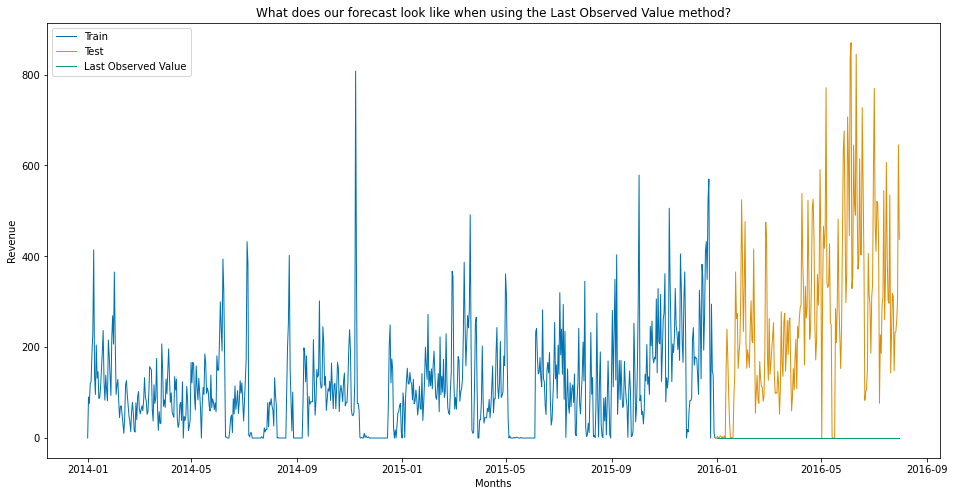

In [71]:
plot_and_eval(model_type="Last Observed Value", target_var="revenue")

## Simple Average
### Predict

In [72]:
revenue = round(train.revenue.mean(), 2)

# predictions DataFrame
yhat = pd.DataFrame({"revenue": [revenue]}, index=test.index)
yhat.head()

,revenue
date,
2016-01-01,110.51
2016-01-02,110.51
2016-01-03,110.51
2016-01-04,110.51
2016-01-05,110.51


### Evaluate

In [73]:
evaluations = append_eval_df("Simple Average", "revenue")
evaluations.sort_values(by="rmse")

,model_type,target_var,rmse
0,Facebook Prophet,revenue,123.874145
2,Simple Average,revenue,250.000000
1,Last Observed Value,revenue,334.000000


### Plot

The rmse of the Simple Average forecast = 250.0


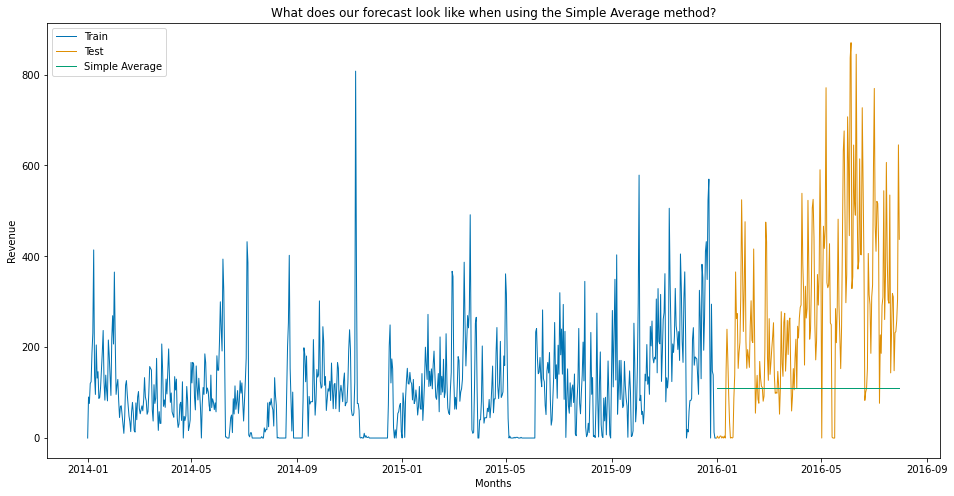

In [74]:
plot_and_eval(model_type="Simple Average", target_var="revenue")

## Moving Average
### Predict

In [75]:
period = 30

revenue = round(train.revenue.rolling(period).mean()[-1], 2)

yhat = pd.DataFrame({"revenue": [revenue]}, index=test.index)
yhat.head()

,revenue
date,
2016-01-01,218.99
2016-01-02,218.99
2016-01-03,218.99
2016-01-04,218.99
2016-01-05,218.99


### Evaluate

In [76]:
evaluations = append_eval_df("30D Moving Average", "revenue")
evaluations.sort_values(by="rmse")

,model_type,target_var,rmse
0,Facebook Prophet,revenue,123.874145
3,30D Moving Average,revenue,196.000000
2,Simple Average,revenue,250.000000
1,Last Observed Value,revenue,334.000000


### Plot

The rmse of the 30D Moving Average forecast = 196.0


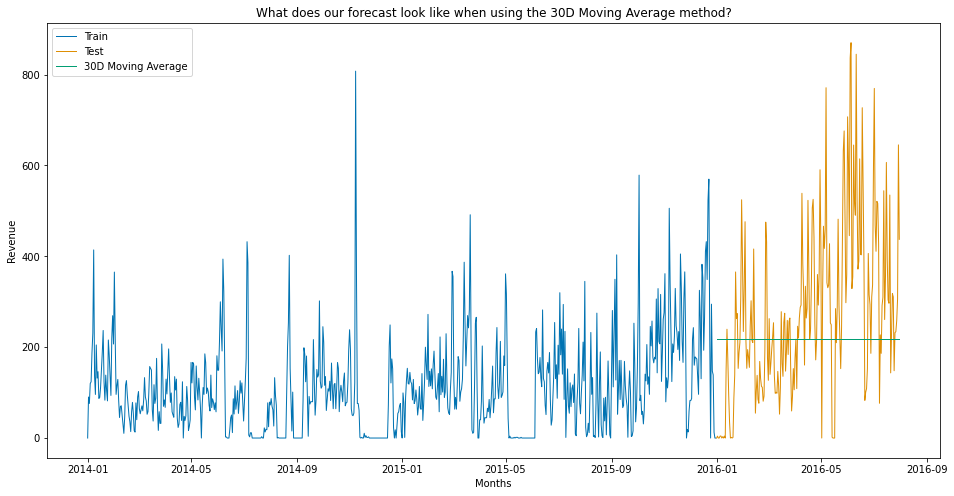

In [77]:
plot_and_eval(model_type="30D Moving Average", target_var="revenue")

### Loop

In [78]:
periods = [60, 90, 180, 365, 548]

for p in periods:
    
    # predict
    revenue = round(train.revenue.rolling(p).mean()[-1], 2)
    
    # store predictions
    yhat = pd.DataFrame({"revenue": [revenue]}, index=test.index)
    
    # model_type
    model_type = str(p) + "D Moving Average"
    
    # append evaluations
    evaluations = append_eval_df(model_type, "revenue")
    
evaluations.sort_values(by="rmse")

,model_type,target_var,rmse
0,Facebook Prophet,revenue,123.874145
3,30D Moving Average,revenue,196.000000
4,60D Moving Average,revenue,197.000000
5,90D Moving Average,revenue,201.000000
6,180D Moving Average,revenue,222.000000
7,365D Moving Average,revenue,236.000000
8,548D Moving Average,revenue,248.000000
2,Simple Average,revenue,250.000000
1,Last Observed Value,revenue,334.000000


## Holt's Linear Trend
### Seasonal Decomposition

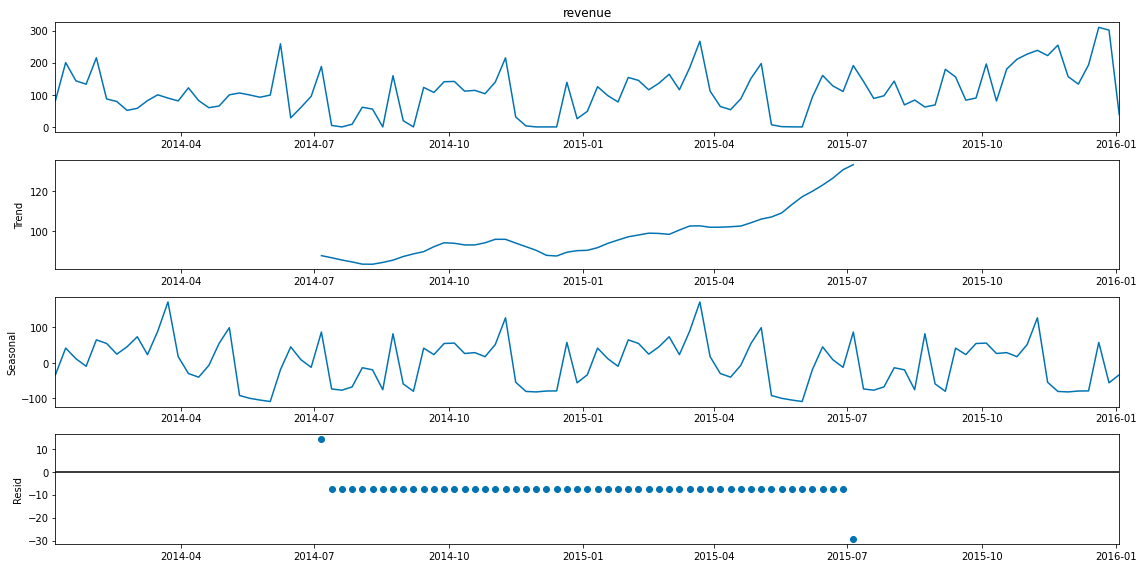

In [79]:
sm.tsa.seasonal_decompose(train.resample("W").revenue.mean()).plot()
plt.show()

### Predict

In [80]:
train = train.resample("D").sum()
train

,revenue
date,
2014-01-01,0.00
2014-01-02,90.30
2014-01-03,76.11
2014-01-04,119.97
2014-01-05,123.84
...,...
2015-12-27,147.34
2015-12-28,139.00
2015-12-29,12.51


In [81]:
model = Holt(train.revenue, exponential=False)
model = model.fit(smoothing_level=.1, smoothing_slope=.1, optimized=False)

In [82]:
yhat_items = model.predict(start=test.index[0], end=test.index[-1])

In [83]:
yhat["revenue"] = round(yhat_items, 2)
yhat.head()

,revenue
date,
2016-01-01,219.45
2016-01-02,216.14
2016-01-03,212.84
2016-01-04,209.54
2016-01-05,206.24


### Evaluate

In [84]:
evaluations = append_eval_df("Holt's Linear Trend", "revenue")
evaluations.sort_values(by="rmse")

,model_type,target_var,rmse
0,Facebook Prophet,revenue,123.874145
3,30D Moving Average,revenue,196.000000
4,60D Moving Average,revenue,197.000000
5,90D Moving Average,revenue,201.000000
6,180D Moving Average,revenue,222.000000
7,365D Moving Average,revenue,236.000000
8,548D Moving Average,revenue,248.000000
2,Simple Average,revenue,250.000000
1,Last Observed Value,revenue,334.000000
9,Holt's Linear Trend,revenue,530.000000


### Plot

The rmse of the Holt's Linear Trend forecast = 530.0


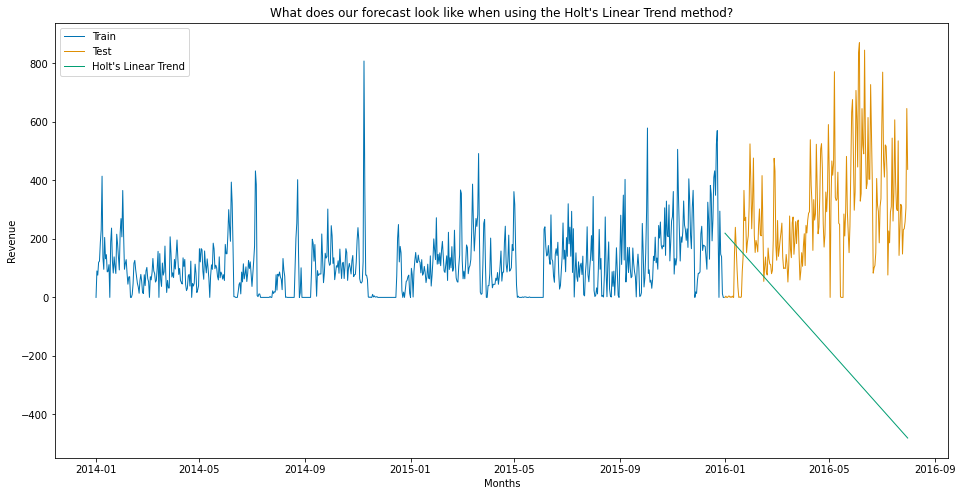

In [85]:
plot_and_eval(model_type="Holt's Linear Trend", target_var="revenue")

## Previous Cycle
### Predict

In [86]:
test.index[-1]

Timestamp('2016-07-31 00:00:00')

In [87]:
yhat = train["2015"] + train.diff(213).mean()
yhat.index = pd.date_range("2016-01-01", periods=len(yhat), freq="D")
yhat = yhat[:"2016-07-31"]
yhat

,revenue
2016-01-01,25.035629
2016-01-02,124.365629
2016-01-03,102.435629
2016-01-04,26.325629
2016-01-05,114.045629
...,...
2016-07-27,125.365629
2016-07-28,163.465629
2016-07-29,236.235629
2016-07-30,150.765629


### Evaluate

In [88]:
evaluations = append_eval_df("Previous 213D Cycle", "revenue")
evaluations.sort_values(by="rmse")

,model_type,target_var,rmse
0,Facebook Prophet,revenue,123.874145
3,30D Moving Average,revenue,196.000000
4,60D Moving Average,revenue,197.000000
5,90D Moving Average,revenue,201.000000
6,180D Moving Average,revenue,222.000000
7,365D Moving Average,revenue,236.000000
10,Previous 213D Cycle,revenue,243.000000
8,548D Moving Average,revenue,248.000000
2,Simple Average,revenue,250.000000
1,Last Observed Value,revenue,334.000000


### Plot

The rmse of the Previous 213D Cycle forecast = 243.0


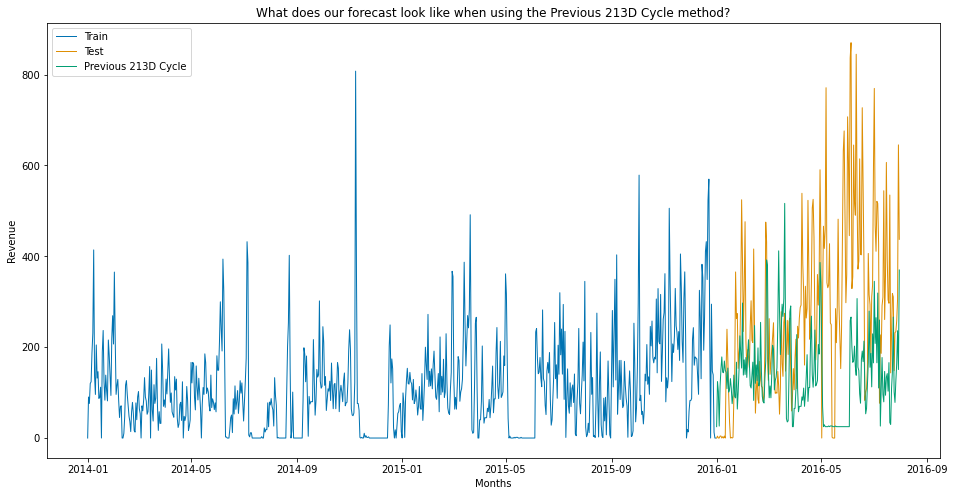

In [89]:
plot_and_eval(model_type="Previous 213D Cycle", target_var="revenue")

# Conclusion

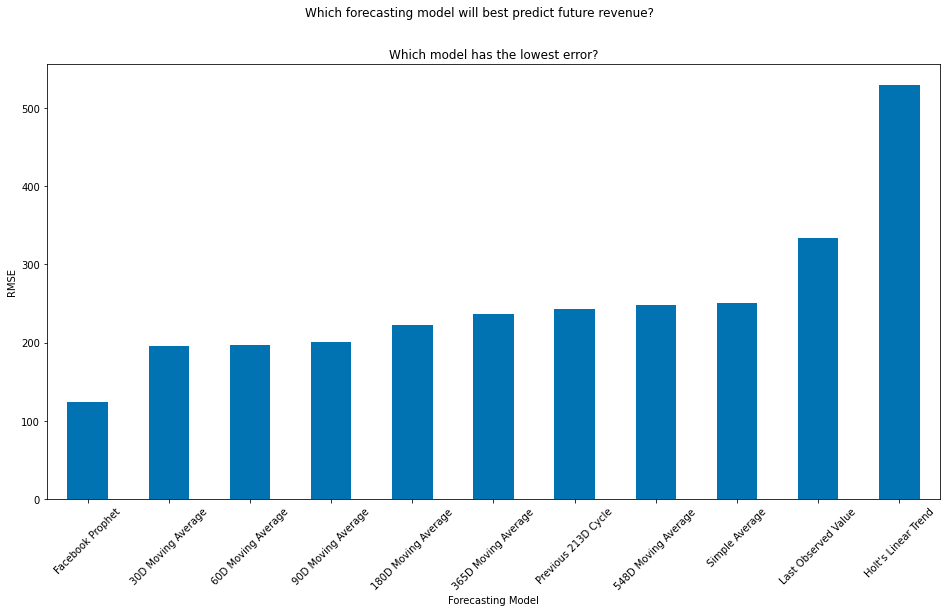

In [90]:
evaluations.set_index("model_type").rmse.sort_values().plot.bar()
plt.suptitle("Which forecasting model will best predict future revenue?")
plt.title("Which model has the lowest error?")
plt.xticks(rotation=45)
plt.xlabel("Forecasting Model")
plt.ylabel("RMSE")
plt.show()

**Takeaway**: We will deploy the Facebook Prophet model to predict future revenue.